In [3]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from stabilize_sequence import stabilize_getshifts, stabilize_apply_shifts, stabilize_crop_to_overlap
from detect_and_label_chambers import detect_circles
from skimage.color import label2rgb
import  skimage.filters
import skimage.morphology

In [ ]:
# sample image 1 (only transmitted light)
im =tifffile.imread("C:/Users/Volker/Data/eggs_jen.tif")
im.shape
#im = im[1:,...]

In [4]:
# sample image 2 (all channels)
seq = tifffile.imread("C:/Users/Volker/Data/20180503 JenEggLinkerCurve_s10.tif")
seq.shape
seq.ndim

TiffPages: invalid page offset (1282595708)
TiffFile.asarray: failed to reshape (388, 1040, 1392) to (97, 2, 1040, 1392)


5

In [ ]:
# some odd things happen here (see error message above)

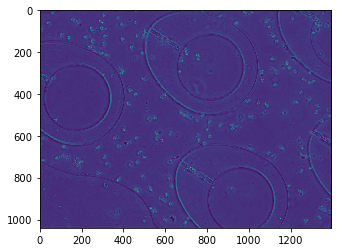

In [5]:
plt.imshow(seq[0,10,1,...])

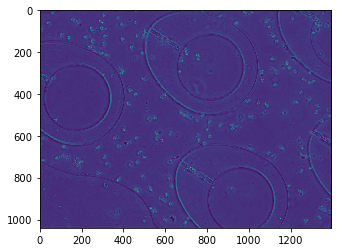

In [6]:
 plt.imshow(seq[1,10,1,...])

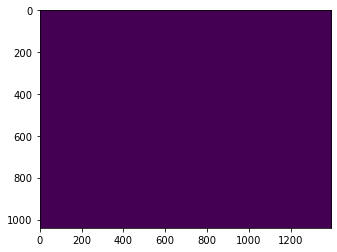

In [8]:
# The first dimension appears to contain duplicate images

# just create a time series of the egg chamber for testing now
im=seq[0,:,1,...]


# Drift correction

In [9]:
shifts = stabilize_getshifts(im)
newim = stabilize_apply_shifts(im, shifts)

# Crop to region where all images overlap and compute temporal median

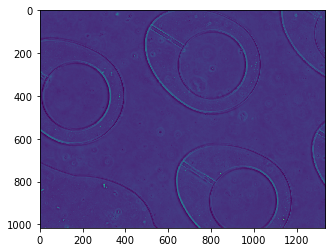

In [10]:
cropped = stabilize_crop_to_overlap(newim)
cropped_median = np.median(cropped, axis=0)
plt.imshow(cropped_median)

# Detect chambers using Hough transform

In [11]:
label_im = detect_circles(cropped_median)

found circles [[[945.5 890.5 166.8]
  [800.5 255.5 167.9]
  [163.5 396.5 163.5]]]


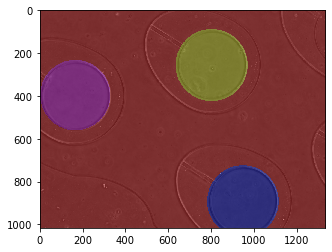

In [12]:
plt.imshow(label2rgb(label_im,cropped_median/cropped_median.max()))

# Cell detection and pre-processing for intensity measurements
note that the values seem to contain some outliers that throw off the automated intensity scaling. Note the difference in automated scaling after applying a gaussian.

Approach: 

* get a first background estimate based on the minimum per pixel over time
* for a single timepoint: apply some smoothing and subtract background
* apply otsu to find cells
* get a per-frame background intensity estimate by taking the median of the intensity in the area outside of the dilated cell mask
* subtract per-frame background intensity


If there are multiple fluorescence channels these steps will have to be done for each channel, except for thresholding which should be done on the DAPI channel.


In [13]:
# stabilize whole sequecnce
import numpy as np
stabseq = stabilize_apply_shifts(seq[0,:,...], shifts)
stabseq = stabilize_crop_to_overlap(stabseq)

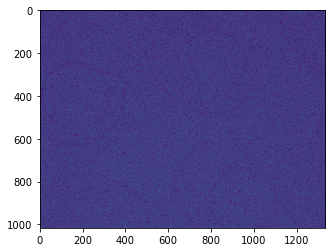

In [14]:
#median_cells = 
plt.imshow(np.min(stabseq[:,0,...], axis=0), vmin=200, vmax=700)

In [55]:
background = skimage.filters.gaussian(np.min(stabseq[:,0,...], axis=0),3)
#background = np.min(stabseq[:,0,...], axis=0)

In [43]:
tuple(range(10)).index(5)

5

In [56]:
cells = stabseq[1,0,...]


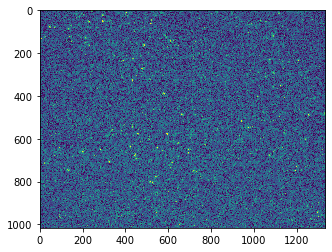

In [57]:
plt.imshow(cells,  interpolation='none', vmin=300, vmax=500)

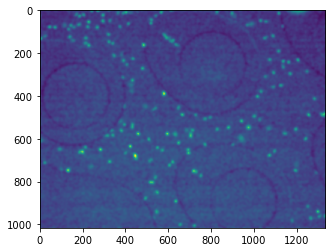

In [58]:
smoothed_cells = skimage.filters.gaussian(cells,5)
plt.imshow(smoothed_cells)

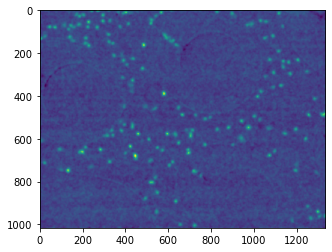

In [59]:
bgcorr = smoothed_cells - background
plt.imshow(bgcorr)

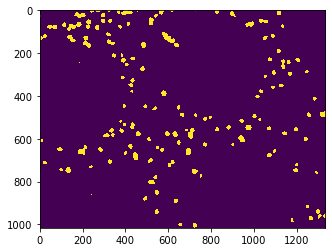

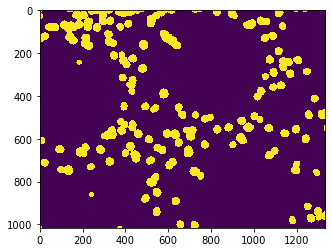

0.0002680358262027358

In [60]:

th = skimage.filters.threshold_otsu(bgcorr)

# TODO prevent getting the wrong threshold when there are no cells !
# set some minimum
cellmask = bgcorr > th
plt.imshow(cellmask)
plt.show()
dilated_mask = skimage.morphology.dilation(cellmask, skimage.morphology.disk(10))
plt.imshow(dilated_mask)
plt.show()
bg_this_frame = np.median(bgcorr[~dilated_mask])
final_bgcorr = bgcorr - bg_this_frame
np.median(final_bgcorr[cellmask])

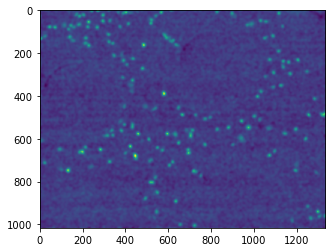

In [54]:
plt.imshow(final_bgcorr)

In [ ]:
# some other tests

TiffPages: invalid page offset (1282595708)
TiffFile.asarray: failed to reshape (388, 1040, 1392) to (97, 2, 1040, 1392)


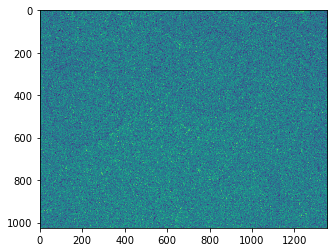

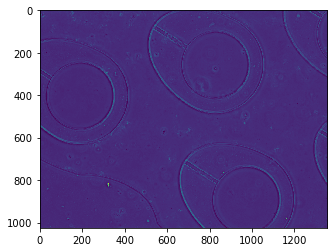

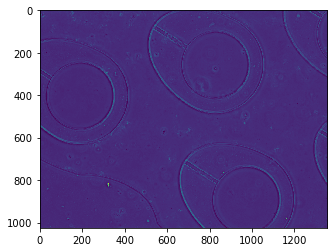

found circles [[[189.5 402.5 158. ]
  [824.5 258.5 167.9]
  [967.5 892.5 173.4]]]


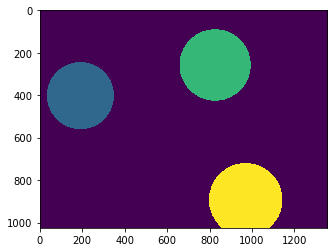

all channes (0, 1, 2)
fluo channels (0, 2)
performing initial background correction
segmeting nuclei ...
refining background correction estimation
Calculating intensity statistics


,label,ch_0_centroid-0,ch_0_centroid-1,ch_0_max_intensity,ch_0_mean_intensity,ch_0_min_intensity,ch_0_area,timepoint,ch_2_centroid-0,ch_2_centroid-1,ch_2_max_intensity,ch_2_mean_intensity,ch_2_min_intensity,ch_2_area,eggchamber,filename,chamberarea
0,1,0,60,0.000140,0.000138,0.000135,2,0,0,60,0.001068,0.001053,0.001038,2,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
1,2,2,397,0.000400,0.000228,0.000134,68,0,2,397,0.006309,0.005316,0.003347,68,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
2,3,0,477,0.000141,0.000139,0.000138,3,0,0,477,0.003393,0.003342,0.003305,3,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
3,4,0,635,0.000170,0.000151,0.000136,11,0,0,635,0.002151,0.002111,0.002068,11,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
4,5,4,1020,0.000661,0.000338,0.000135,168,0,4,1020,0.006141,0.004244,0.001379,168,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
5,6,0,1109,0.000143,0.000140,0.000137,4,0,0,1109,0.002478,0.002206,0.001863,4,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
6,7,0,1197,0.000156,0.000148,0.000139,5,0,0,1197,0.000051,0.000020,0.000004,5,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
7,8,0,1223,0.000214,0.000168,0.000135,20,0,0,1223,-0.000010,-0.000059,-0.000079,20,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
8,9,0,1235,0.000181,0.000160,0.000145,10,0,0,1235,0.000089,0.000084,0.000080,10,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043
9,10,0,1247,0.000167,0.000149,0.000135,12,0,0,1247,0.001945,0.001147,0.000605,12,0,C:/Users/Volker/Data/20180503 JenEggLinkerCurv...,1135043


In [2]:
from process_experiment import *
%matplotlib inline
measurements = process_timeseries("C:/Users/Volker/Data/20180503 JenEggLinkerCurve_s10.tif", {})
measurements